# Calculate distances between specific residues in pdb files

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from os.path import exists
from biopandas.pdb import PandasPdb

UNRELAXED_PDB_SUFFIX = '-unrelaxed_model_1.pdb'
RELAXED_PDB_SUFFIX = '-relaxed_model_1.pdb'
RESULTS_PKL_SUFFIX = '-result_model_1_ptm.pkl'

def sanitize_protein(protein_id):
    """Replace / in protein ID with _ for compatibility with file system"""
    return protein_id.replace("/", "_")

def calculate_dist(pdb, XL):
    """Calculate the distance between residues in the PDB based on the crosslink"""
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == XL.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == XL.Res2]
    
    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    
    return np.linalg.norm(res_1_coords - res_2_coords)

In [41]:
# Read in XL csv file to pandas DF
XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding= 'unicode_escape')

# Save all intramolecular crosslinks to a new DF
XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

# Calculate the XL position in the protein primary sequence
XLs_intra.loc[:,'Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
XLs_intra.loc[:,'Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

# Removes all XL redundancies 
XLs_intra.loc[:,'newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
XLs_intra.loc[:,'newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [62]:
# Extract XL counts
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(columns = {'index': 'Protein1', 'Protein1': 'XL_count'})
XLs_intra_nonred.loc[:,'af_distance'] = None
XLs_intra_nonred

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
13,14,413.29,RSPH4A/6A-2,86,KLLDPLMEGEEDNLAPVGAIGYVPNFMEEAK,1,RSPH4A/6A-2,72,EKYEAVSESFKANK,11,86,82,86,82,None
20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,6,941,926,941,926,None
35,36,369.15,I7LU32,298,TQIHTSYGLNQHKEAISLFR,13,I7LU32,318,KVQGGQK,1,310,318,318,310,None
70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,1,744,752,752,744,None
75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,7,351,414,414,351,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19421,19422,146.57,IFT52,40,NKEDITYDR,2,IFT52,33,ETYKCGR,4,41,36,41,36,None
19422,19423,155.26,IFT144,965,LNLDKLDNLR,5,IFT144,935,QYAKAK,4,969,938,969,938,None
19424,19425,132.32,CCT5,46,SSLGPKGMDK,6,CCT5,173,VVSKNKR,6,51,178,178,51,None
19425,19426,155.99,IFT81,480,NKTEYDQMLKK,10,IFT81,491,LEKEK,3,489,493,493,489,None


In [67]:
pdbs = {}

def read_pdb_ca(pdb_filepath):
    ppdb = PandasPdb().read_pdb(pdb_filepath) # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM'] # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name']=='CA')] # selects the only the CA atoms

def read_protein_pdb(protein, pdb_suffix):
    if pdb_suffix not in pdbs:
        pdbs[pdb_suffix] = {}
    elif protein in pdbs[pdb_suffix]:
        return pdbs[pdb_suffix][protein]
    pdbs_with_suffix = pdbs[pdb_suffix]

    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if not exists(pdb_filepath):
        # print(protein + ' PDB file not found. Skipping...')
        return None
    pdb_ca = read_pdb_ca(pdb_filepath)

    pdbs_with_suffix[protein] = pdb_ca
    return pdb_ca

def fill_xls_from_pdb(protein_name, threshold, pdb):
    XLs_intra_nonred['af_distance'] = XLs_intra_nonred.apply(lambda x : x.af_distance if x.Protein1 != protein_name else calculate_dist(pdb, x), axis = 1)
    return XLs_intra_nonred[(XLs_intra_nonred['af_distance'] < threshold) & (XLs_intra_nonred['Protein1'] == protein_name)]

def get_af_xl_counts(protein_xl_counts, threshold, pdb_suffix):
    protein = protein_xl_counts['Protein1']
    pdb_ca = read_protein_pdb(protein, pdb_suffix)
    if pdb_ca is None:
        return None
    return fill_xls_from_pdb(protein, threshold, pdb_ca).count()['Id']

In [68]:
intra_XL_counts['af_XL_count'] = intra_XL_counts.apply(lambda x : get_af_xl_counts(x, 40, UNRELAXED_PDB_SUFFIX), axis = 1)
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

# ACBD7 has an invalid character, re-download PDB later

,Protein1,XL_count,af_XL_count
4,PRKG1,38,38.0
5,EEF2,35,30.0
6,MRNC57,34,27.0
9,EMAP5/6-1,30,30.0
10,I7MJ59,30,18.0
...,...,...,...
120,I7LW80,8,8.0
121,I7LZI8,7,6.0
123,I7MEJ5,7,7.0
128,I7MHD4,7,7.0


## Compare Confidence and XL Agreement

In [45]:
def read_confidence(intra_xl_counts):
    protein = intra_xl_counts['Protein1']
    
    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if not exists(ranking_filepath):
        #print(protein + ' ranking file not found. Skipping...')
        return None
    
    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        return ranking_debug['plddts']['model_1']

intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x : read_confidence(x), axis = 1)

In [46]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
4,PRKG1,38,38.0,78.041609,1.000000
5,EEF2,35,30.0,89.479929,0.857143
6,MRNC57,34,27.0,68.385990,0.794118
9,EMAP5/6-1,30,30.0,NaN,1.000000
10,I7MJ59,30,18.0,67.924191,0.600000
...,...,...,...,...,...
120,I7LW80,8,8.0,68.536852,1.000000
121,I7LZI8,7,6.0,97.085454,0.857143
123,I7MEJ5,7,7.0,80.420044,1.000000
128,I7MHD4,7,7.0,95.693012,1.000000


<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

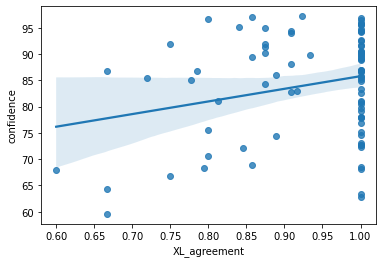

In [47]:
sns.regplot(x = intra_XL_counts['XL_agreement'], y = intra_XL_counts['confidence'])

## Compare Unrelaxed vs Relaxed XL counts for top 10 most crosslinked proteins

In [48]:
intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(lambda x : get_af_xl_counts(x, 40, RELAXED_PDB_SUFFIX), axis = 1)
intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_XL_count']
intra_XL_counts[intra_XL_counts['af_relaxed_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,38.0,78.041609,1.000000,38.0,1.000000,0.0
5,EEF2,35,30.0,89.479929,0.857143,30.0,0.857143,0.0
6,MRNC57,34,27.0,68.385990,0.794118,26.0,0.764706,-1.0
9,EMAP5/6-1,30,30.0,NaN,1.000000,30.0,1.000000,0.0
10,I7MJ59,30,18.0,67.924191,0.600000,20.0,0.666667,2.0
11,BBC118,25,18.0,85.481704,0.720000,18.0,0.720000,0.0
12,FTT18,25,21.0,95.138586,0.840000,21.0,0.840000,0.0
13,EARS,24,24.0,91.715565,1.000000,24.0,1.000000,0.0
14,EMAP5/6-2,22,22.0,NaN,1.000000,22.0,1.000000,0.0
16,Q23A15,20,16.0,75.527561,0.800000,15.0,0.750000,-1.0


## Examine PAE pattern in protein PRKG1 and EEF2 to see how to extract domains

In [174]:
import matplotlib.pyplot as plt

def plot_plddt(protein):
    sanitized_protein = sanitize_protein(protein)
    results = pd.read_pickle('results/' + sanitized_protein + RESULTS_PKL_SUFFIX)

    plddt = results['plddt']

    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    plt.plot(plddt)
    plt.title('Predicted LDDT')
    plt.xlabel('Residue')
    plt.ylabel('pLDDT')


def plot_pae(protein, xl_thresholds):
    sanitized_protein = sanitize_protein(protein)

    results = pd.read_pickle('results/' + sanitized_protein + RESULTS_PKL_SUFFIX)

    pae = results['predicted_aligned_error']
    max_pae = results['max_predicted_aligned_error']

    protein_xls = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]

    figure = plt.figure(figsize=(15, 15))
    figure.patch.set_facecolor('white')
    subplot_index = 1

    for xl_threshold in xl_thresholds:
        plt.subplot(1, len(xl_thresholds), subplot_index)
        subplot_index += 1

        protein_xls_agreed = protein_xls[protein_xls['af_distance'] <= xl_threshold]
        protein_xls_missed = protein_xls[protein_xls['af_distance'] > xl_threshold]

        # plt.subplot(1, 2, 2)
        plt.imshow(pae, vmin=0., vmax=max_pae, cmap='Blues_r')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.scatter(protein_xls_agreed['newRes1'], protein_xls_agreed['newRes2'], marker='o', facecolors='none', edgecolors='yellow')
        plt.scatter(protein_xls_missed['newRes1'], protein_xls_missed['newRes2'], marker='D', facecolors='none', edgecolors='purple')

        plt.title(protein + ' Predicted Aligned Error, XL Threshold ' + str(xl_threshold))
        plt.xlabel('Scored residue')
        plt.ylabel('Aligned residue')

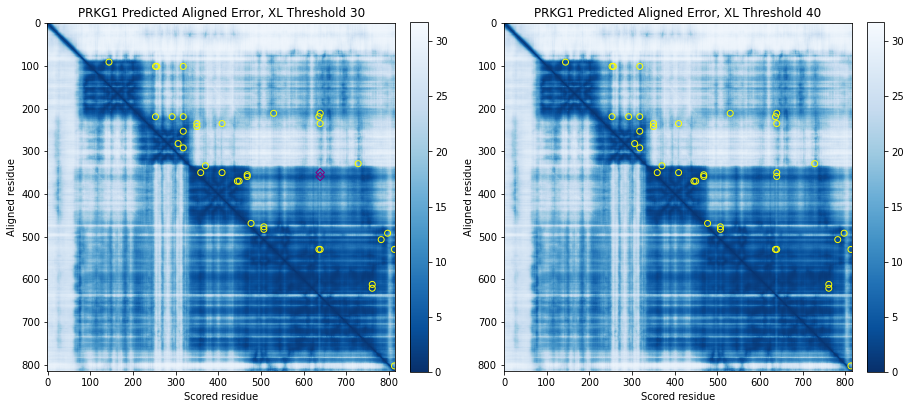

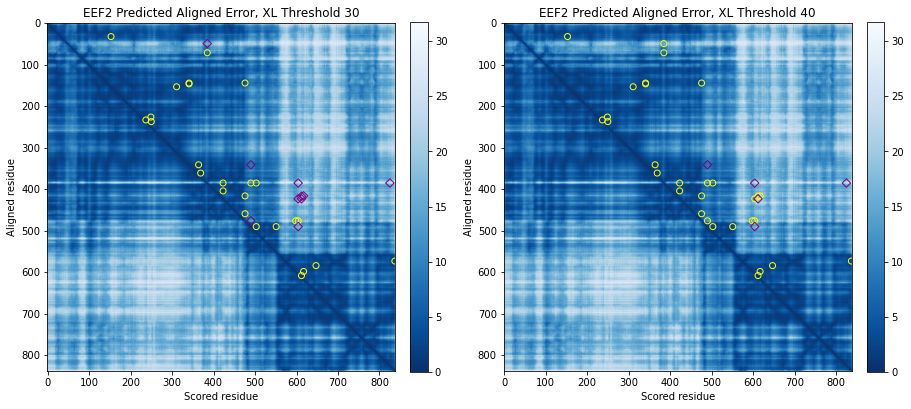

In [177]:
pae_proteins = ['PRKG1', 'EEF2']
thresholds = [30, 40]

for pae_protein in pae_proteins:
    plot_pae(pae_protein, thresholds)